In [292]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from os import listdir
import pickle

In [329]:
DATA_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/data_2'
RESULTS_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/results'
TRANSITION_RESULTS_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/results/transition-influence'
MODELS = ['ss', 'ss-sampler', 'ff']
N_PARAM_BINS = 4

# Model colors
MODEL_COLORS = {
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}

# Parameter colors
ALPHA_COLORS = sns.cubehelix_palette(
    n_colors = N_PARAM_BINS,
    start = 2.5,
    rot = 0.2,
    light = 0.7,
    dark = 0.1
)
BETA_COLORS = sns.cubehelix_palette(
    n_colors = N_PARAM_BINS,
    start = 1.5,
    rot = 0.2,
    light = 0.7,
    dark = 0.1
)
SEGMENTATION_COLORS = sns.cubehelix_palette(
    n_colors = N_PARAM_BINS,
    start = .5,
    rot = 0.2,
    light = 0.7,
    dark = 0.1
)

# Functions

## Helper Functions

In [330]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def get_frequent_targets(df):
    """
    Get frequent targets from a DataFrame

    Arguments
    ---------
    df : pd.DataFrame
        Choice phase data
    
    Returns
    -------
    None
    """
    df['freq'] = 0
    idx = (
        (df['target'] == '[1 4 0 0]') |
        (df['target'] == '[4 1 0 0]') |
        (df['target'] == '[0 0 1 4]') |
        (df['target'] == '[0 0 4 1]') 
    )
    df.loc[idx, 'freq'] = 1

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

## Plot Functions

In [349]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.axvline(np.max(df['trial'])/2, color='black')
    for block in df['block'].unique():
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[:-n_labels],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        ax.axhline(1, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, 2)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

# Load Data

## Training

In [332]:
# Load training data
training_df = []
for model in MODELS:
    training_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/training'))
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)

# Label blocks
n_training_trials = np.max(training_df['trial'])
training_df['block'] = (training_df['trial'] > n_training_trials/2) + 1

# Label frequent targets
get_frequent_targets(training_df)

training_df

,id,model_label,alpha,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,conjunctive_composition,...,options_comb,target,options,composition,successor,p,reward,correct,block,freq
0,1572,ss,0.536239,3.137813,3.137813,1.0,1.000000,True,True,True,...,[1 1 1 0 0],[4 4 4 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[3 2 2 0 0],[4 1 1 0 0],0.125000,1,0,1,0
1,1572,ss,0.536239,3.137813,3.137813,1.0,1.000000,True,True,True,...,[1 1 1 0 0],[4 4 1 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[2 3 2 0 0],[1 4 1 0 0],0.125000,2,0,1,0
2,1572,ss,0.536239,3.137813,3.137813,1.0,1.000000,True,True,True,...,[1 1 1 0 0],[1 4 1 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[3 3 2 0 0],[4 4 1 0 0],0.136738,2,0,1,0
3,1572,ss,0.536239,3.137813,3.137813,1.0,1.000000,True,True,True,...,[1 1 1 0 0],[1 1 1 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[2 3 3 0 0],[1 4 4 0 0],0.125000,1,0,1,0
4,1572,ss,0.536239,3.137813,3.137813,1.0,1.000000,True,True,True,...,[1 1 1 0 0],[4 1 4 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[2 2 3 0 0],[1 1 4 0 0],0.125000,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431995,385,ff,0.181693,0.547890,0.547890,1.0,0.283929,False,False,False,...,[1 0 0 1 1],[4 0 0 4 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 0 2 0]...,[2 0 0 3 2],[1 0 0 4 1],0.041563,2,0,2,0
431996,385,ff,0.181693,0.547890,0.547890,1.0,0.283929,False,False,False,...,[1 0 0 1 1],[4 0 0 4 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 0 2 0]...,[3 0 0 3 2],[4 0 0 4 1],0.332834,3,1,2,0
431997,385,ff,0.181693,0.547890,0.547890,1.0,0.283929,False,False,False,...,[1 0 0 1 1],[1 0 0 4 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 0 2 0]...,[2 0 0 3 3],[1 0 0 4 4],0.216311,2,0,2,0
431998,385,ff,0.181693,0.547890,0.547890,1.0,0.283929,False,False,False,...,[1 0 0 1 1],[1 0 0 4 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 0 2 0]...,[2 0 0 3 3],[1 0 0 4 4],0.255570,2,0,2,0


## Test

In [333]:
test_df = []
for model in MODELS:
    test_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/test'))
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df

,id,model_label,alpha,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,conjunctive_composition,...,trial,target_comb,options_comb,target,options,composition,successor,p,reward,correct
0,1119,ss,0.604867,2.632592,2.632592,1.0,1.000000,True,True,True,...,2,[1 0 0 1 1],[1 1 1 0 0],[1 0 0 1 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[3 3 3 0 0],[4 4 4 0 0],0.125,0,0
1,1119,ss,0.604867,2.632592,2.632592,1.0,1.000000,True,True,True,...,3,[1 0 0 1 1],[1 1 0 1 0],[1 0 0 1 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[2 2 0 2 0],[1 1 0 1 0],0.125,2,0
2,1119,ss,0.604867,2.632592,2.632592,1.0,1.000000,True,True,True,...,4,[1 0 0 1 1],[1 1 0 0 1],[1 0 0 1 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[3 2 0 0 3],[4 1 0 0 4],0.125,0,0
3,1119,ss,0.604867,2.632592,2.632592,1.0,1.000000,True,True,True,...,5,[1 0 0 1 1],[1 0 1 1 0],[1 0 0 1 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 2 0 0]...,[3 0 3 3 0],[4 0 4 4 0],0.125,0,0
4,1119,ss,0.604867,2.632592,2.632592,1.0,1.000000,True,True,True,...,6,[1 0 0 1 1],[1 0 1 0 1],[1 0 0 1 1],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 2 0 0]...,[2 0 2 0 3],[1 0 1 0 4],0.125,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863995,149,ff,0.464903,8.419018,8.419018,1.0,0.012506,False,False,False,...,285,[1 1 1 0 0],[1 1 0 1 0],[4 4 4 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[3 3 0 3 0],[4 4 0 4 0],1.000,2,0
863996,149,ff,0.464903,8.419018,8.419018,1.0,0.012506,False,False,False,...,286,[1 1 1 0 0],[1 1 0 0 1],[4 4 4 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 2 0 0 0]...,[3 3 0 0 3],[4 4 0 0 4],1.000,2,0
863997,149,ff,0.464903,8.419018,8.419018,1.0,0.012506,False,False,False,...,287,[1 1 1 0 0],[1 0 1 1 0],[4 4 4 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 2 0 0]...,[3 0 2 3 0],[4 0 1 4 0],1.000,1,0
863998,149,ff,0.464903,8.419018,8.419018,1.0,0.012506,False,False,False,...,288,[1 1 1 0 0],[1 0 1 0 1],[4 4 4 0 0],[[[2 0 0 0 0]\n [3 0 0 0 0]]\n\n [[0 0 2 0 0]...,[3 0 2 0 3],[4 0 1 0 4],1.000,1,0


## Subject Information 

In [334]:
subj_df = test_df[['id', 'model_label', 'alpha', 'beta', 'segmentation']]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df

,id,model_label,alpha,beta,segmentation
0,1119,ss,0.604867,2.632592,1.000000
1,1131,ss,0.342060,1.602646,1.000000
2,1657,ss,0.289936,8.911278,1.000000
3,1643,ss,0.336130,1.243376,1.000000
4,1125,ss,0.975370,42.883080,1.000000
...,...,...,...,...,...
2995,161,ff,0.984755,0.555725,0.111002
2996,607,ff,0.113624,0.885448,0.194875
2997,613,ff,0.937780,1.169767,0.115368
2998,175,ff,0.390268,2.080072,0.287564


## Transition Influence

In [299]:
trans_influence_df = []
for fname in listdir(TRANSITION_RESULTS_PATH):

    # Get agent ID from file name
    agent_id = int(fname.replace('.pkl', '').split('_')[1])

    # Load trace
    with open(f'{TRANSITION_RESULTS_PATH}/{fname}', 'rb') as f:
        trace = pickle.load(f)

    # Extract coefficients
    coefs = az.summary(trace)['mean'].values
    coefs = coefs.reshape(-1, 2)

    try:
        # Add to full results set
        coefs_df = pd.DataFrame({
            'id': agent_id,
            'action': [1, 2, 3],
            'incidental': coefs[:, 0],
            'true': coefs[:, 1]
        })
        trans_influence_df.append(coefs_df)

    except:

        print(f'ISSUE WITH AGENT {agent_id} COEFS')

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information
trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = 'id'
)

trans_influence_df

ISSUE WITH AGENT 869 COEFS
ISSUE WITH AGENT 449 COEFS
ISSUE WITH AGENT 588 COEFS


,id,action,transition,coef,model_label,alpha,beta,segmentation
0,785,1,incidental,3.717,ff,0.757805,5.659580,0.553743
1,785,2,incidental,2.288,ff,0.757805,5.659580,0.553743
2,785,3,incidental,0.562,ff,0.757805,5.659580,0.553743
3,785,1,true,1.749,ff,0.757805,5.659580,0.553743
4,785,2,true,1.351,ff,0.757805,5.659580,0.553743
...,...,...,...,...,...,...,...,...
4591,953,2,incidental,0.450,ff,0.582714,0.011191,0.530584
4592,953,3,incidental,-0.140,ff,0.582714,0.011191,0.530584
4593,953,1,true,0.075,ff,0.582714,0.011191,0.530584
4594,953,2,true,-0.348,ff,0.582714,0.011191,0.530584


# Training Analysis

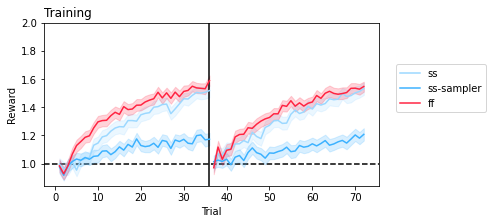

In [60]:
plot_training_curve(
    training_df,
    'reward',
    'model_label',
    palette = MODEL_COLORS
)

## Feature-Based Model

In [347]:
def round_interval_labels(interval_series, n):
    return interval_series.apply(
        lambda x: pd.Interval(
            round(x.left, n),
            round(x.right, n)
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned

In [348]:
# Get feature-based model data
idx = training_df['model_label'] == 'ff'
ff_training_df = training_df.loc[idx]
ff_training_df = ff_training_df.reset_index(drop=True)

# Bin parameters
ff_training_df['alpha_bin'] = bin_params(
    ff_training_df['alpha'],
    N_PARAM_BINS
)
ff_training_df['beta_bin'] = bin_params(
    ff_training_df['beta'],
    N_PARAM_BINS,
    method = pd.qcut
)
ff_training_df['segmentation_bin'] = bin_params(
    ff_training_df['segmentation'],
    N_PARAM_BINS
)

### Learning Rate

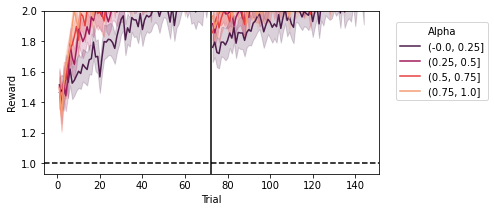

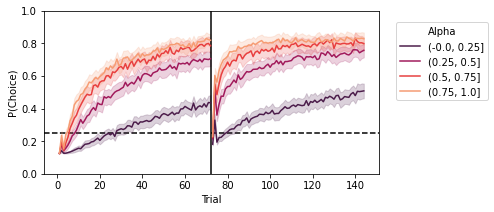

In [336]:
plot_training_curve(
    ff_training_df,
    'reward',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha'
)

plot_training_curve(
    ff_training_df,
    'p',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha'
)

### Inverse Temperature

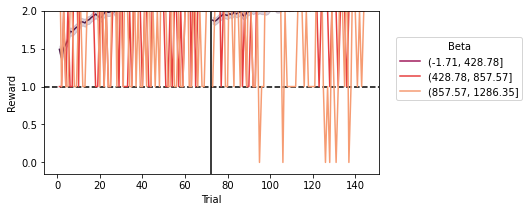

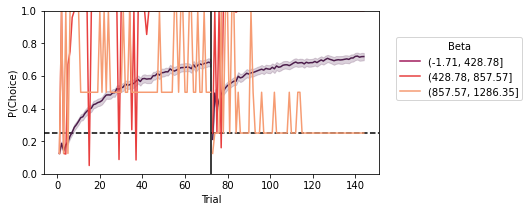

In [337]:
plot_training_curve(
    ff_training_df,
    'reward',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta'
)

plot_training_curve(
    ff_training_df,
    'p',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta'
)

### Segmentation

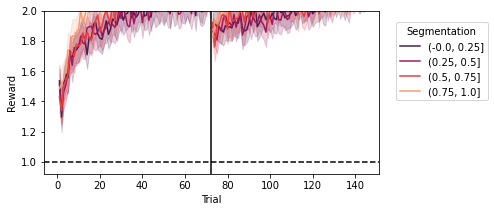

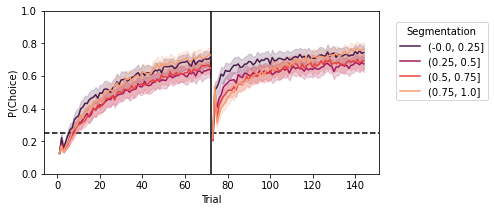

In [338]:
plot_training_curve(
    ff_training_df,
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation'
)

plot_training_curve(
    ff_training_df,
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation'
)

In [339]:
def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        chance = 1
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, 2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)


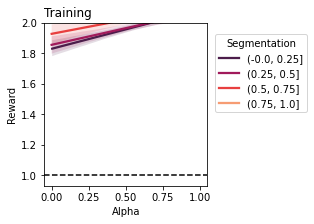

In [340]:
plot_param_interaction(
        ff_training_df,
        'alpha',
        'segmentation_bin',
        'reward',
        title = 'Training',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
)

### Transition Influence

<AxesSubplot:xlabel='alpha', ylabel='coef'>

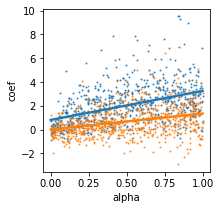

In [305]:
plot_df = trans_influence_df[[
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
idx = plot_df['transition'] == 'true'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    ax = ax
)

idx = plot_df['transition'] == 'incidental'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    ax = ax
)

<AxesSubplot:xlabel='segmentation', ylabel='coef'>

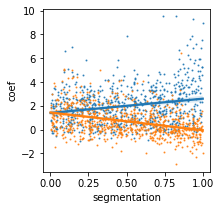

In [306]:
plot_df = trans_influence_df[[
    'id',
    'segmentation',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'segmentation',
    'transition'
])
plot_df = plot_df.mean().reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
idx = plot_df['transition'] == 'true'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'segmentation',
    y = 'coef',
    scatter_kws = {'s': 1},
    ax = ax
)

idx = plot_df['transition'] == 'incidental'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'segmentation',
    y = 'coef',
    scatter_kws = {'s': 1},
    ax = ax
)

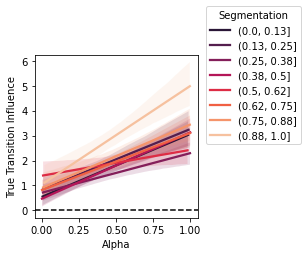

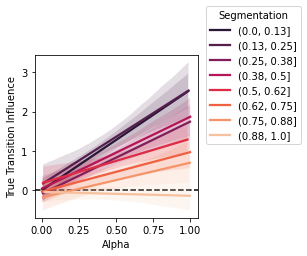

In [328]:
trans_influence_df['segmentation_bin'] = cut_params(
    trans_influence_df['segmentation'],
    N_PARAM_BINS
)

idx = trans_influence_df['transition'] == 'true'
plot_param_interaction(
        trans_influence_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'True Transition Influence',
        palette = 'rocket'
)

idx = trans_influence_df['transition'] == 'incidental'
plot_param_interaction(
        trans_influence_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'True Transition Influence',
        palette = 'rocket'
)